In [16]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Nadam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
import shutil
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!pip install kaggle

In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle

In [7]:
!kaggle datasets download -d kylegraupe/skin-cancer-binary-classification-dataset

 40% 9.00M/22.5M [00:00<00:00, 84.0MB/s]
100% 22.5M/22.5M [00:00<00:00, 154MB/s] 


In [8]:
!unzip /content/skin-cancer-binary-classification-dataset.zip

Archive:  /content/skin-cancer-binary-classification-dataset.zip
  inflating: Skin_Data/Cancer/Testing/1714-02.jpg  
  inflating: Skin_Data/Cancer/Testing/1718-2.jpg  
  inflating: Skin_Data/Cancer/Testing/1777-1.JPG  
  inflating: Skin_Data/Cancer/Testing/1780.1.JPG  
  inflating: Skin_Data/Cancer/Testing/1780.JPG  
  inflating: Skin_Data/Cancer/Testing/1789-02.JPG  
  inflating: Skin_Data/Cancer/Testing/1811-3.JPG  
  inflating: Skin_Data/Cancer/Testing/1847 (7).JPG  
  inflating: Skin_Data/Cancer/Testing/1847.JPG  
  inflating: Skin_Data/Cancer/Testing/1861-02.JPG  
  inflating: Skin_Data/Cancer/Testing/1864-1.JPG  
  inflating: Skin_Data/Cancer/Testing/1877(2).JPG  
  inflating: Skin_Data/Cancer/Testing/1877.JPG  
  inflating: Skin_Data/Cancer/Testing/1905.JPG  
  inflating: Skin_Data/Cancer/Testing/1969-1.JPG  
  inflating: Skin_Data/Cancer/Testing/1969-2.JPG  
  inflating: Skin_Data/Cancer/Testing/1988-01.JPG  
  inflating: Skin_Data/Cancer/Testing/1991 (1).JPG  
  inflating: Ski

In [3]:
!pip install -q Augmentor

In [9]:
path_to_training_dataset = '/content/Skin_Data/'
class_names = ['Cancer','Non_Cancer']
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i + '/Training', output_directory='/content/sample_data/Train/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(4200)

Initialised with 42 image(s) found.
Output directory set to /content/sample_data/Train/Cancer.

Processing <PIL.Image.Image image mode=RGB size=290x210 at 0x7ACD100E6DD0>: 100%|██████████| 4200/4200 [01:53<00:00, 36.87 Samples/s]


Initialised with 42 image(s) found.
Output directory set to /content/sample_data/Train/Non_Cancer.

Processing <PIL.Image.Image image mode=RGB size=350x360 at 0x7ACCFFF0FF10>: 100%|██████████| 4200/4200 [00:48<00:00, 86.65 Samples/s]


In [10]:
data_dir = '/content/Skin_Data'  # Update this to your dataset directory
output_dir = '/content/sample_data/Test'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create subdirectories for train and valid (no test directory)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)


# Define the classes for binary classification
classes = ['Cancer', 'Non_Cancer']

# Move data from source to train/valid folders
for class_name in classes:
    class_dir = os.path.join(data_dir,class_name,"Testing")

    # Create subdirectories for train and valid within each class
    os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, 'valid', class_name), exist_ok=True)

    # List all files in the current class directory
    files = os.listdir(class_dir)


    # Move files to train
    for file in files:
        source_path = os.path.join(class_dir, file)
        dest_path = os.path.join(output_dir, 'test', class_name, file)
        shutil.copyfile(source_path, dest_path)

print("Data preprocessing for binary classification complete.")

Data preprocessing for binary classification complete.


In [11]:
batch_size = 16
img_height = 180
img_width = 180

In [12]:
output_dir = '/content/sample_data/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8400 files belonging to 2 classes.
Using 6720 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8400 files belonging to 2 classes.
Using 1680 files for validation.


In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/sample_data/Test/test',
  seed=123,
  validation_split = 0.9,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 204 files belonging to 2 classes.
Using 183 files for validation.


In [23]:
input_shape = (img_height,img_width,3)
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=input_shape)])
model.add(Conv2D(16,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(128,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [24]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
420/420 [==============================] - 19s 35ms/step - loss: 0.6277 - accuracy: 0.9384 - val_loss: 5.3763 - val_accuracy: 0.7286
Epoch 2/20
420/420 [==============================] - 15s 35ms/step - loss: 0.2861 - accuracy: 0.9804 - val_loss: 0.1511 - val_accuracy: 0.9786
Epoch 3/20
420/420 [==============================] - 14s 33ms/step - loss: 0.2249 - accuracy: 0.9863 - val_loss: 0.0392 - val_accuracy: 0.9958
Epoch 4/20
420/420 [==============================] - 14s 34ms/step - loss: 0.1219 - accuracy: 0.9905 - val_loss: 0.0226 - val_accuracy: 0.9982
Epoch 5/20
420/420 [==============================] - 15s 34ms/step - loss: 0.1148 - accuracy: 0.9946 - val_loss: 0.4262 - val_accuracy: 0.9714
Epoch 6/20
420/420 [==============================] - 14s 34ms/step - loss: 0.0451 - accuracy: 0.9976 - val_loss: 5.5499 - val_accuracy: 0.8679
Epoch 7/20
420/420 [==============================] - 17s 39ms/step - loss: 0.2739 - accuracy: 0.9897 - val_loss: 5.0038 - val_accuracy:

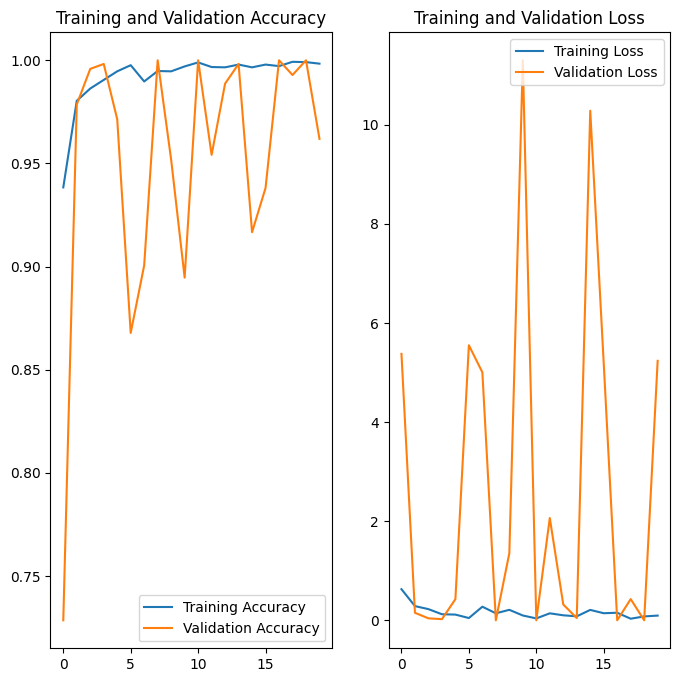

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size)

12/12 [==============================] - 0s 27ms/step - loss: 44.6544 - accuracy: 0.8470


In [28]:
model.save("Binary Cancer 85%acc.h5")

In [109]:
true_categories = np.array(tf.concat([y for x, y in test_ds], axis=0))

In [108]:
predictions = np.array(model.predict(test_ds))
pred_categories = []
for pred in predictions:
  if(pred[0] >= 0.5):
    pred_categories.append(1)
  else:
    pred_categories.append(0)
pred_categories = np.array(pred_categories)

12/12 [==============================] - 0s 9ms/step


In [110]:
true_categories

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [111]:
pred_categories

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [104]:
pd.crosstab(true_categories,pred_categories)

col_0,0,1
row_0,,
0,11,26
1,36,110


In [106]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(true_categories,pred_categories))

              precision    recall  f1-score   support

           0       0.23      0.30      0.26        37
           1       0.81      0.75      0.78       146

    accuracy                           0.66       183
   macro avg       0.52      0.53      0.52       183
weighted avg       0.69      0.66      0.68       183



In [112]:
from tensorflow.keras.preprocessing import image

In [113]:
img = image.load_img('/content/sample_data/Test/test/Cancer/1992.JPG',target_size =(180,180))

In [114]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =model.predict(x)
if(float(pred[0]) >= 0.5):
    print("Non Cancer")
else:
    print("Cancer")
score = float(pred[0])
print(f"This image is {100 * (1 - score):.2f}% Cancer and {100 * score:.2f}% Non Cancer.")

1/1 [==============================] - 0s 46ms/step
Cancer
This image is 100.00% Cancer and 0.00% Non Cancer.
